In [1]:
import os

import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label, binary_erosion, binary_dilation, disk
from skimage.morphology import square, watershed, closing, binary_closing
from skimage.morphology import remove_small_holes, remove_small_objects
from skimage.filters.rank import gradient
from skimage.exposure import rescale_intensity
from skimage.segmentation import random_walker

from sklearn.model_selection import KFold

from scipy.ndimage.morphology import binary_fill_holes

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.optimizers import Adam

import tensorflow as tf

import pickle as pkl
import gc

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

C:\Users\deepi\newer\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import cv2
import random as rn

In [3]:
# Getting path of images
#modify according to your directory
TRAIN_PATH = '../input/Andrew/'

train_ids = next(os.walk(TRAIN_PATH))[1]

np.random.seed(0)
perm = np.random.permutation(len(train_ids))
train_ids = [train_ids[i] for i in perm]

In [4]:
#importing the training data
#concatenations of the masks
train = []
train_mask = []
test = []

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    file = "C:/Users/deepi/Desktop/project/input/Andrew/{}/image/{}.tif".format(id_,id_)
    mfile = "C:/Users/deepi/Desktop/project/input/Andrew/{}/mask/*.png".format(id_)
    image = cv2.imread(file)
    image = rescale_intensity(image, out_range=np.uint8)
    masks = imread_collection(mfile).concatenate()
    train.append(image)
    train_mask.append(masks)

100%|██████████| 90/90 [00:34<00:00,  2.60it/s]


In [5]:
#preprocessing the training images
def preprocess(image):
   
    if (image[:,:,0] != image[:,:,1]).any():
        return image

    img_gray=image[:,:,1]
    
    circle7=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    img_open=cv2.morphologyEx(img_gray, cv2.MORPH_OPEN, circle7)
    
    img_th=cv2.threshold(img_open,0,255,cv2.THRESH_OTSU)[1]
    
    if (np.sum(img_th==255)>np.sum(img_th==0)):
        return image
    else:
        return 255 - image

In [6]:
train = [preprocess(image) for image in train]

In [7]:
#splitting the images into two overlapping images to form a square
#To minimize distortion of nuclei size
def split_aux(img):
    height = img.shape[0]
    width = img.shape[1]
    if height > 2*width:
        half = int(height//2)
        return [img[:half, :, :], img[half:, :, :]]
    elif height > width:
        return [img[:width, :, :], img[height-width:, :, :]]
    elif width > 2*height:
        half = int(width//2)
        return [img[:, :half, :], img[:, half:, :]]
    else:
        return [img[:, :height, :], img[:, width-height:, :]]

def split(img):
    s = split_aux(img)
    return s

def split_mask_aux(img):
    height = img.shape[1]
    width = img.shape[2]
    if height > 2*width:
        half = int(height//2)
        return [img[:, :half, :], img[:, half:, :]]
    elif height > width:
        return [img[:, :width, :], img[:, height-width:, :]]
    elif width > 2*height:
        half = int(width//2)
        return [img[:, :, :half], img[:, :, half:]]
    else:
        return [img[:, :, :height], img[:, :, width-height:]]

def split_mask(img):
    s = split_mask_aux(img)
    return s

In [8]:
train_split = [split(img) for img in train]
train_split = [t_split[i] for t_split in train_split for i in [0, 1] ]

train_mask_split = [split_mask(img) for img in train_mask]
train_mask_split = [t_split[i] for t_split in train_mask_split for i in [0, 1] ]

In [9]:
#Resizing and augmenting the images to feed into input layer of the network
X_train = np.zeros((len(train_split) * 4, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), np.uint8)
Y_train = np.zeros((len(train_split) * 4, IMG_HEIGHT, IMG_WIDTH, 1), np.uint8)
Z_train = np.zeros((len(train_split) * 4, IMG_HEIGHT, IMG_WIDTH, 3), np.uint8)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, (img, masks) in enumerate(zip(tqdm(train_split), train_mask_split)):
    img = img[:, :, :IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    img_mean = np.mean(img, axis=2).astype(np.uint8)
    for c in range(IMG_CHANNELS):
        img[:,:,c] = img_mean
    X_train[n * 4 + 0] = img
    X_train[n * 4 + 1] = np.fliplr(img)
    X_train[n * 4 + 2] = np.flipud(img)
    X_train[n * 4 + 3] = np.flipud(np.fliplr(img))

    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), np.uint8)
    mask_lr = np.zeros((IMG_HEIGHT, IMG_WIDTH), np.uint8)
    mask_ud = np.zeros((IMG_HEIGHT, IMG_WIDTH), np.uint8)
    mask_lr_ud = np.zeros((IMG_HEIGHT, IMG_WIDTH), np.uint8)
    for mask_id in range(masks.shape[0]):
        mask_ = masks[mask_id, :, :]
        mask_ = mask_ // 255
        mask_ = resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                       preserve_range=True).astype(np.uint8)
        mask = np.maximum(mask, mask_)
        mask_lr = np.maximum(mask_lr, np.fliplr(mask_))
        mask_ud = np.maximum(mask_ud, np.flipud(mask_))
        mask_lr_ud = np.maximum(mask_lr_ud, np.flipud(np.fliplr(mask_)))
        
    Y_train[4*n + 0, :, :, 0] = mask
    Y_train[4*n + 1, :, :, 0] = mask_lr
    Y_train[4*n + 2, :, :, 0] = mask_ud
    Y_train[4*n + 3, :, :, 0] = mask_lr_ud
  
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), np.uint8)
    mask_lr = np.zeros((IMG_HEIGHT, IMG_WIDTH), np.uint8)
    mask_ud = np.zeros((IMG_HEIGHT, IMG_WIDTH), np.uint8)
    mask_lr_ud = np.zeros((IMG_HEIGHT, IMG_WIDTH), np.uint8)
    for mask_id in range(masks.shape[0]):
        mask_ = masks[mask_id, :, :]
        mask_ = mask_ // 255
        mask_ = resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                       preserve_range=True).astype(np.uint8)
        mask_ = binary_dilation(mask_, selem=square(3))
        mask += mask_
        mask_lr += np.fliplr(mask_)
        mask_ud += np.flipud(mask_)
        mask_lr_ud += np.flipud(np.fliplr(mask_))
        
    Z_train[4*n + 0, :, :, 0] = (mask > 1)
    Z_train[4*n + 1, :, :, 0] = (mask_lr > 1)
    Z_train[4*n + 2, :, :, 0] = (mask_ud > 1)
    Z_train[4*n + 3, :, :, 0] = (mask_lr_ud > 1)

Getting and resizing train images and masks ... 


100%|██████████| 180/180 [00:31<00:00,  5.72it/s]


In [10]:
for i in tqdm(range(len(train_split) * 4)):
    Z_train[i, :, :, 1] = Y_train[i, :, :, 0]
    Z_train[i, :, :, 2] = np.where(Z_train[i, :, :, 0] == 1, 0, 1 - Y_train[i, :, :, 0])

100%|██████████| 720/720 [00:00<00:00, 4339.94it/s]


In [12]:
#saving the images in pkl file.
#uploading images to google colab takes time
#saving as pkl saves to time to upload
fname = 'andrew'
with open('../data/X_train_%s.pkl' % fname, 'wb') as file:
    pkl.dump(X_train, file, protocol=pkl.HIGHEST_PROTOCOL)

with open('../data/Z_train_%s.pkl' % fname, 'wb') as file:
    pkl.dump(Z_train, file, protocol=pkl.HIGHEST_PROTOCOL)


23 (2000, 2000, 3)


C:\Users\deepi\newer\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


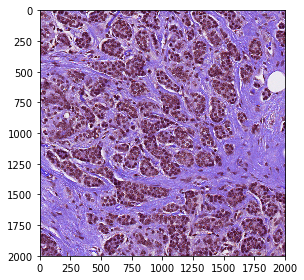

184 (256, 256, 3)


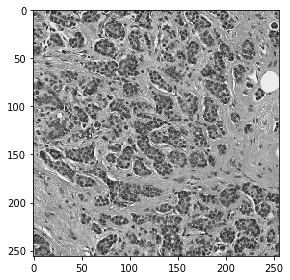

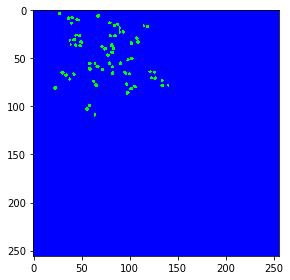

185 (256, 256, 3)


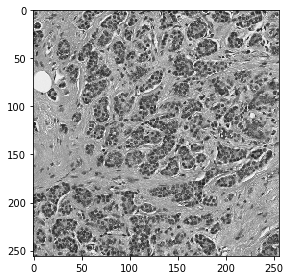

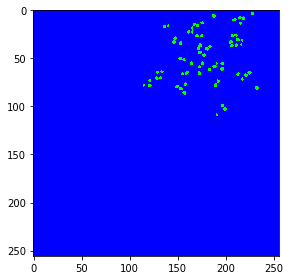

In [15]:
#checking the pre processed images and masks
ix = random.randint(0, len(train_ids))
print(ix, train[ix].shape)
imshow(train[ix])
plt.show()

for i in range(8*ix, 8*ix + 2):
    print(i, X_train[i].shape)
    imshow(X_train[i])
    plt.show()
    imshow(255*Z_train[i])
    plt.show()